In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import os.path
from datetime import datetime

env = gym.make('SpaceInvaders-v4')

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
[2017-12-13 02:45:01,058] Making new env: SpaceInvaders-v4


In [2]:
def conv(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')

def preprocess(obs):
    obs = cv2.cvtColor(cv2.resize(obs,(84, 110)), cv2.COLOR_BGR2GRAY)
    obs = obs[26:110,:]
    ret, obs = cv2.threshold(obs,1,255,cv2.THRESH_BINARY)
    return np.reshape(obs, [84,84,1])

In [3]:
class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = 100000
        
    def write(self, data):
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1
        
    def read(self, batch_size):
        return random.sample(self.buffer,min(batch_size,self.length))

In [4]:
class Network:
    
    def __init__(self, session, image_size, n_out):
        
        self.session = session
        self.image_size = image_size
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = n_out
        
        self.n1 = 32
        self.n2 = 32
        self.n3 = 64
        self.n4 = 512
         
        self.x = tf.placeholder(tf.float32, [None, self.h, self.w, self.num_channels], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        self.x_image = tf.reshape(self.x, [-1, self.h, self.w, self.num_channels])
        
        self.W_conv1 = tf.get_variable('W_conv1', shape=[8, 8, self.num_channels, self.n1])
        self.b_conv1 = tf.get_variable('b_conv1', shape=[self.n1])
        self.h_conv1 = tf.add(conv(self.x_image, self.W_conv1), self.b_conv1)
        
        self.W_conv2 = tf.get_variable('W_conv2', shape=[6, 6, self.n1, self.n2])
        self.b_conv2 = tf.get_variable('b_conv2', shape=[self.n2])
        self.h_conv2 = tf.add(conv(self.h_conv1, self.W_conv2), self.b_conv2)
       
        self.W_conv3 = tf.get_variable('W_conv3', shape=[4, 4, self.n2, self.n3])
        self.b_conv3 = tf.get_variable('b_conv3', shape=[self.n3])
        self.h_conv3 = tf.add(conv(self.h_conv2, self.W_conv3), self.b_conv3)
        
        self.h_conv3_flat = tf.reshape(self.h_conv3, [-1, 121*self.n3])
        self.W_fc1 = tf.get_variable('W_fc1', shape=[121*self.n3, self.n4])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n4])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_conv3_flat, self.W_fc1), self.b_fc1))
        
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n4,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='q_values')
        
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1, self.h, self.w, self.num_channels])})
    
    def train(self, x_batch, y_batch):
        
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})



class Agent: 
    
    def __init__(self, tf_session):
        self.image_size = (84, 84, 3)
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = 6
        
        self.total_reward = 0 
        
        self.gamma = 0.99
        self.epsilon = 1
        self.batch_size = 36
        
        self.replay_buffer = Replay()
        
        self.q = Network(tf_session, self.image_size , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        
        if np.random.rand() > self.epsilon:
            q_compute = self.q.compute(observation)
            return np.argmax(q_compute)
        else:
            return np.random.choice(list(range(6)))
        
    def q_update(self):
        
        sars_batch = self.replay_buffer.read(self.batch_size)
        
        q_last = self.q.compute([s[0] for s in sars_batch])
        
        q_this = np.zeros_like(q_last)
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        
        x_batch = np.zeros([np.shape(sars_batch)[0],self.h, self.w, self.num_channels])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(6):
                if j == sars_batch[i][1]:
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

Training starts -- 02:45:02
After 50 episodes, last 50 rewards averaged 130.0 -- 02:50:54
After 100 episodes, last 50 rewards averaged 150.0 -- 02:56:54
After 150 episodes, last 50 rewards averaged 126.3 -- 03:02:32
After 200 episodes, last 50 rewards averaged 159.7 -- 03:08:55
After 250 episodes, last 50 rewards averaged 129.8 -- 03:14:55
After 300 episodes, last 50 rewards averaged 137.3 -- 03:21:02
After 350 episodes, last 50 rewards averaged 159.0 -- 03:27:13
After 400 episodes, last 50 rewards averaged 141.3 -- 03:33:28
After 450 episodes, last 50 rewards averaged 182.9 -- 03:40:21
After 500 episodes, last 50 rewards averaged 152.6 -- 03:47:07
After 550 episodes, last 50 rewards averaged 154.2 -- 03:53:49
After 600 episodes, last 50 rewards averaged 151.3 -- 04:00:34
After 650 episodes, last 50 rewards averaged 165.1 -- 04:07:30
After 700 episodes, last 50 rewards averaged 164.8 -- 04:14:02
After 750 episodes, last 50 rewards averaged 164.1 -- 04:20:47
After 800 episodes, last 50 

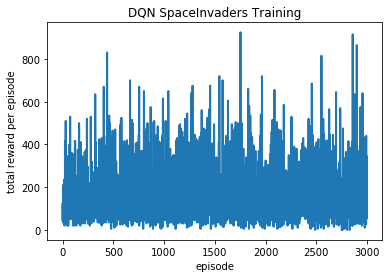

In [5]:
MODEL_LOG_DIR = './final_model'
if not os.path.exists(MODEL_LOG_DIR):
    os.makedirs(MODEL_LOG_DIR)

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

ep_rewards = []       
agent = Agent(sess)
        
sess.run(tf.global_variables_initializer())      
saver = tf.train.Saver()
        
date_object = datetime.now()
current_time = date_object.strftime('%H:%M:%S')
print("Training starts -- {}".format(current_time))
        
for ep in range(3000): 
    
    agent.set_total_reward(0)
    
    # stack observations
    
    # initilize
    last_observation = preprocess(env.reset())
    observation = np.zeros((84,84,3))
    action = env.action_space.sample()
    for i in range (3):
        observation_frame, reward, done, info = env.step(action)
        observation_frame = preprocess(observation_frame)
        observation[:,:,i] = observation_frame[:,:,0]
        agent.gather_reward(reward)
    
    last_observation = observation
    
    for t in range(10000):
        
        action = agent.choose_action(last_observation)
        observation = np.zeros((84,84,3))
        reward = []
        for i in range (3):
            observation_frame, reward_frame, done, info = env.step(action)
            observation_frame = preprocess(observation_frame)
            observation[:,:,i] = observation_frame[:,:,0]
            agent.gather_reward(reward_frame)
            reward.append(reward_frame)
            if done == True:
                 break
                
        if done==True:
            observation = None
                
        agent.gather_experience(last_observation, action, sum(reward)/300, observation)
        agent.q_update()
        last_observation = observation
                
        if done==True or t==9999:
            ep_rewards.append(agent.get_total_reward())
            break
                    
    # print('Episode #{} finished after {} steps, with reward {}'.format(ep+1, t+1, ep_rewards[ep]))
            
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(ep_rewards[-50:]), current_time))
            
    agent.set_epsilon(ep)
            
saver.save(sess, MODEL_LOG_DIR+'/trained_model', global_step=3000)
np.savetxt(MODEL_LOG_DIR+"/{}_rewards.csv".format(ep+1), ep_rewards, delimiter=",")

plt.plot(ep_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Training')
plt.show()

After 50 episodes, last 50 rewards averaged 100.9
After 100 episodes, last 50 rewards averaged 91.2
After 150 episodes, last 50 rewards averaged 86.1
After 200 episodes, last 50 rewards averaged 82.4


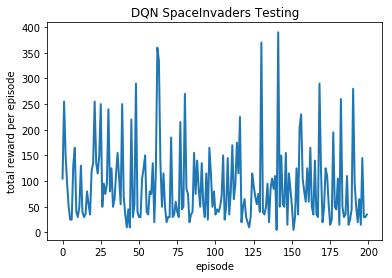

In [6]:
test_rewards = []
for ep in range(200): 
    
    agent.set_total_reward(0)
    agent.reset_epsilon()
    
    last_observation = preprocess(env.reset())
    observation = np.zeros((84,84,3))
    action = env.action_space.sample()
    for i in range (3):
        observation_frame, reward_frame, done, info = env.step(action)
        observation_frame = preprocess(observation_frame)
        observation[:,:,i] = observation_frame[:,:,0]
        agent.gather_reward(reward_frame)
    
    last_observation = observation
    
    for t in range(10000):
        
        action = agent.choose_action(last_observation)
        observation = np.zeros((84,84,3))
        
        for i in range (3):
            observation_frame, reward_frame, done, info = env.step(action)
            observation_frame = preprocess(observation_frame)
            observation[:,:,i] = observation_frame[:,:,0]
            agent.gather_reward(reward_frame)
            
            if done == True:
                 break
                
        if done==True:
            observation = None
        
        last_observation = observation
                
        if done==True or t==9999:
            test_rewards.append(agent.get_total_reward())
            break
                    
    # print('Episode #{} finished after {} steps, with reward {}'.format(ep+1, t+1, ep_rewards[ep]))
            
    if (ep+1) % 50 == 0:
        print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(test_rewards[-50:])))

plt.plot(test_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Testing')
plt.show()